In [135]:
# Vamos a utilizar modelos NO SUPERVISADOS para tratar de segmentar los clientes en X grupos, 
# y revisar si alguno de esos grupos encaja con el segmento de cliente que buscamos

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler


# -------------------------------------------------------------------------
# 1. PREPARACIÓN DE DATOS
# -------------------------------------------------------------------------
# Carga tu dataframe
df = pd.read_csv('../data/processed/clean_data.csv') 

X = df.drop(columns='ID') # Eliminamos el ID que no nos aporta nada útil para predecir

# Escalamos los datos:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

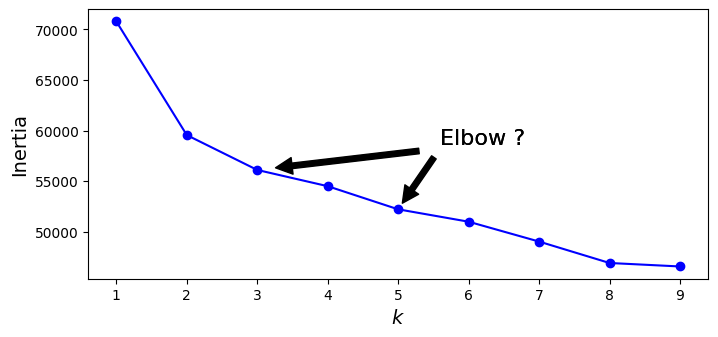

In [137]:
# Probamos varios KMeans para probar dónde obtenemos el mejor compromiso entre K / información agrupada
# (Buscamos el Elbow):

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_scaled)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow ?',
             xy=(3, inertias[2]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.annotate('Elbow ?',
             xy=(5, inertias[4]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )

plt.show()


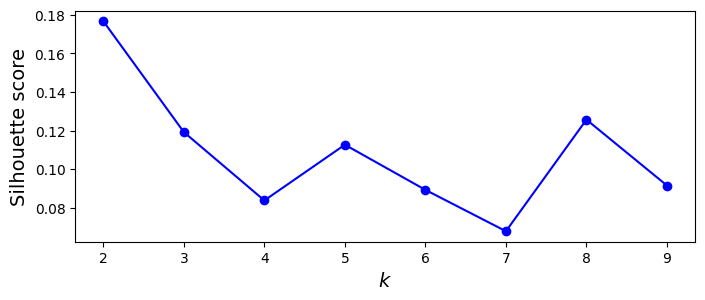

In [138]:
# Verificamos también el silhouette score 

silhouette_scores = [silhouette_score(X_scaled, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7])
#save_fig("silhouette_score_vs_k_plot")
plt.show()

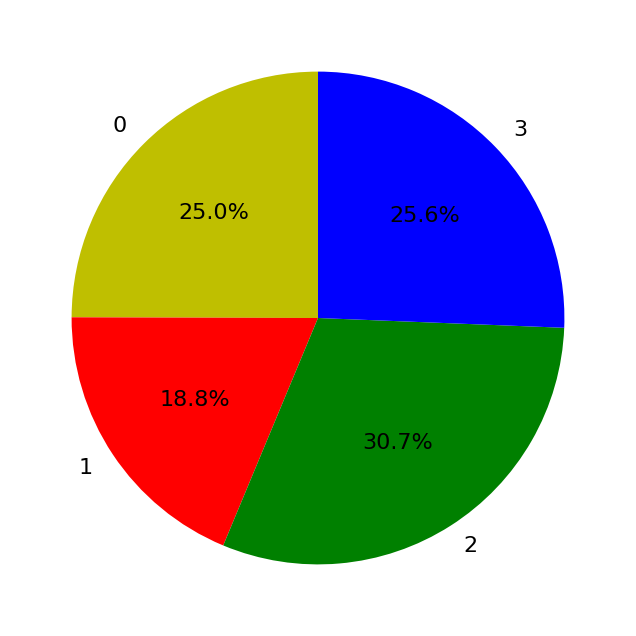

In [139]:
# El silhouete score con K=4 no es el mejor, pero vamos a utilizarlo ya que tampoco hay diferencias muy significativas entre unos y otros
# 
# Vamos a representar qué distribución presentan estos 4 clusteres
k = 4
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
y_pred = kmeans.fit_predict(X_scaled)

unique_values, counts = np.unique(y_pred, return_counts=True)
colores = ['y', 'r', 'g', 'b'] # Rojo, Verde, Azul, Amarillo

# Draw the pie plot
plt.figure(figsize=(8, 8))

plt.pie(
    counts,
    colors=colores,
    labels=unique_values,
    autopct='%1.1f%%',  # Format to show percentage on the slices
    textprops={'fontsize': 16},
    startangle=90       # Start the plot from the top
)

# Add a title
# plt.title(f'Distribución en {k} clusters')
plt.show();

In [140]:
# Están bastante bien distribuidos
    

In [141]:
# Veamos si tenemos Clusters de clientes cuyo consumo de vino está por encima/por debajo de la media

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns) # Convierto X_Scaled nuevamente en un dataframe

etiquetas_kmeans = kmeans.labels_ 
X_scaled_df['Cluster'] = etiquetas_kmeans

importancia_exhibida_por_targets_en_cada_cluster = X_scaled_df.groupby('Cluster')[['Target_MntWinesYear', 'Target_Campaign_Responsiveness']].mean()
importancia_exhibida_por_targets_en_cada_cluster


,Target_MntWinesYear,Target_Campaign_Responsiveness
Cluster,,
0,0.598132,0.049904
1,-0.669856,-0.223469
2,-0.800036,-0.324866
3,0.864632,0.503443


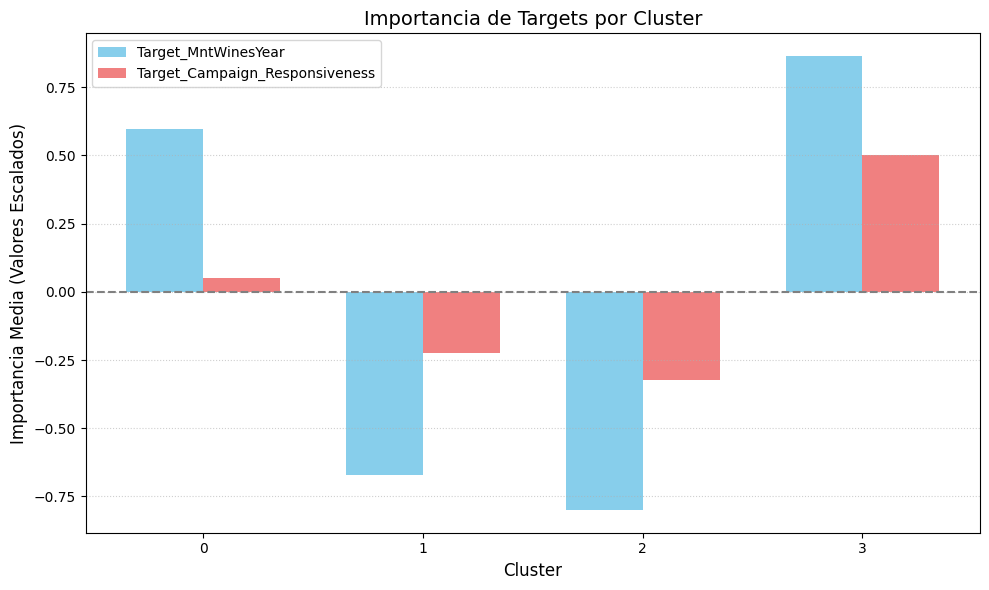

In [142]:
# Mostramos la importancia que exhiben las variables a predecir por Cluster en un gráfico:

# Resetear el índice para que 'Cluster' sea una columna y facilitar el ploteo
df_plot_importancia = importancia_exhibida_por_targets_en_cada_cluster.reset_index()

# 2. Definir Parámetros del Gráfico
clusters = df_plot_importancia['Cluster']
n_clusters = len(clusters)
bar_width = 0.35  # Ancho de las barras
index = np.arange(n_clusters)  # Posiciones para el eje X

# Valores para la primera variable
val_vines = df_plot_importancia['Target_MntWinesYear']

# Valores para la segunda variable
val_campaign = df_plot_importancia['Target_Campaign_Responsiveness']

# 3. Crear el Gráfico
plt.figure(figsize=(10, 6))

# Barra para 'Target_MntWinesYear' (Desplazada a la izquierda)
plt.bar(index - bar_width/2, val_vines, bar_width, 
        label='Target_MntWinesYear', color='skyblue')

# Barra para 'Target_Campaign_Responsiveness' (Desplazada a la derecha)
plt.bar(index + bar_width/2, val_campaign, bar_width, 
        label='Target_Campaign_Responsiveness', color='lightcoral')

# 4. Personalizar el Gráfico

# Eje X: Etiquetas de los clusters
plt.xlabel('Cluster', fontsize=12)
plt.xticks(index, clusters, rotation=0)

# Eje Y: Importancia (Media de la variable escalada)
plt.ylabel('Importancia Media (Valores Escalados)', fontsize=12)
plt.title('Importancia de Targets por Cluster', fontsize=14)

# Línea de referencia en Y=0 (para visualizar positivo/negativo si los datos están centrados)
plt.axhline(0, color='gray', linestyle='--')

# Leyenda
plt.legend(loc='upper left')

# Mejorar el diseño
plt.grid(axis='y', linestyle='dotted', alpha=0.6)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [143]:
# - Vemos claramente que los Clusters 0 y 3 consumen por encima de la media (cero representa la media en StandardScaler)
# - También vemos que el CLuster 3 es el que mejor responde a las campañas, por lo que podríamos decir que el Cluster 3 
# es el que más se parece a nuestro público objetivo 

In [144]:
X_scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2212 entries, 0 to 2211
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Year_Birth                      2212 non-null   float64
 1   Income                          2212 non-null   float64
 2   Kidhome                         2212 non-null   float64
 3   Teenhome                        2212 non-null   float64
 4   Recency                         2212 non-null   float64
 5   NumDealsPurchases               2212 non-null   float64
 6   NumWebPurchases                 2212 non-null   float64
 7   NumCatalogPurchases             2212 non-null   float64
 8   NumStorePurchases               2212 non-null   float64
 9   NumWebVisitsMonth               2212 non-null   float64
 10  Complain                        2212 non-null   float64
 11  Target_Campaign_Responsiveness  2212 non-null   float64
 12  Dt_Customer_Unix_time_seconds   22

In [145]:
kmeans.cluster_centers_.shape

(4, 32)

--- 🔬 1. Análisis de los Centroides Estandarizados (Importancia por Desviación) ---

Ranking de Importancia por Desviación Estándar de Centroides:
MntMeatProductsYear               0.9052
Income                            0.9035
NumCatalogPurchases               0.8800
Target_MntWinesYear               0.8549
NumStorePurchases                 0.8541
MntFishProductsYear               0.8055
NumWebPurchases                   0.7633
MntSweetProductsYear              0.7617
MntFruitsYear                     0.7580
NumWebVisitsMonth                 0.7153
Kidhome                           0.7053
Education_Graduation              0.6481
Teenhome                          0.6175
MntGoldProdsYear                  0.6150
Education_Master                  0.5635
NumDealsPurchases                 0.5264
Education_PhD                     0.5117
Target_Campaign_Responsiveness    0.3701
Year_Birth                        0.3059
Dt_Customer_Unix_time_seconds     0.2565
Education_Basic                  

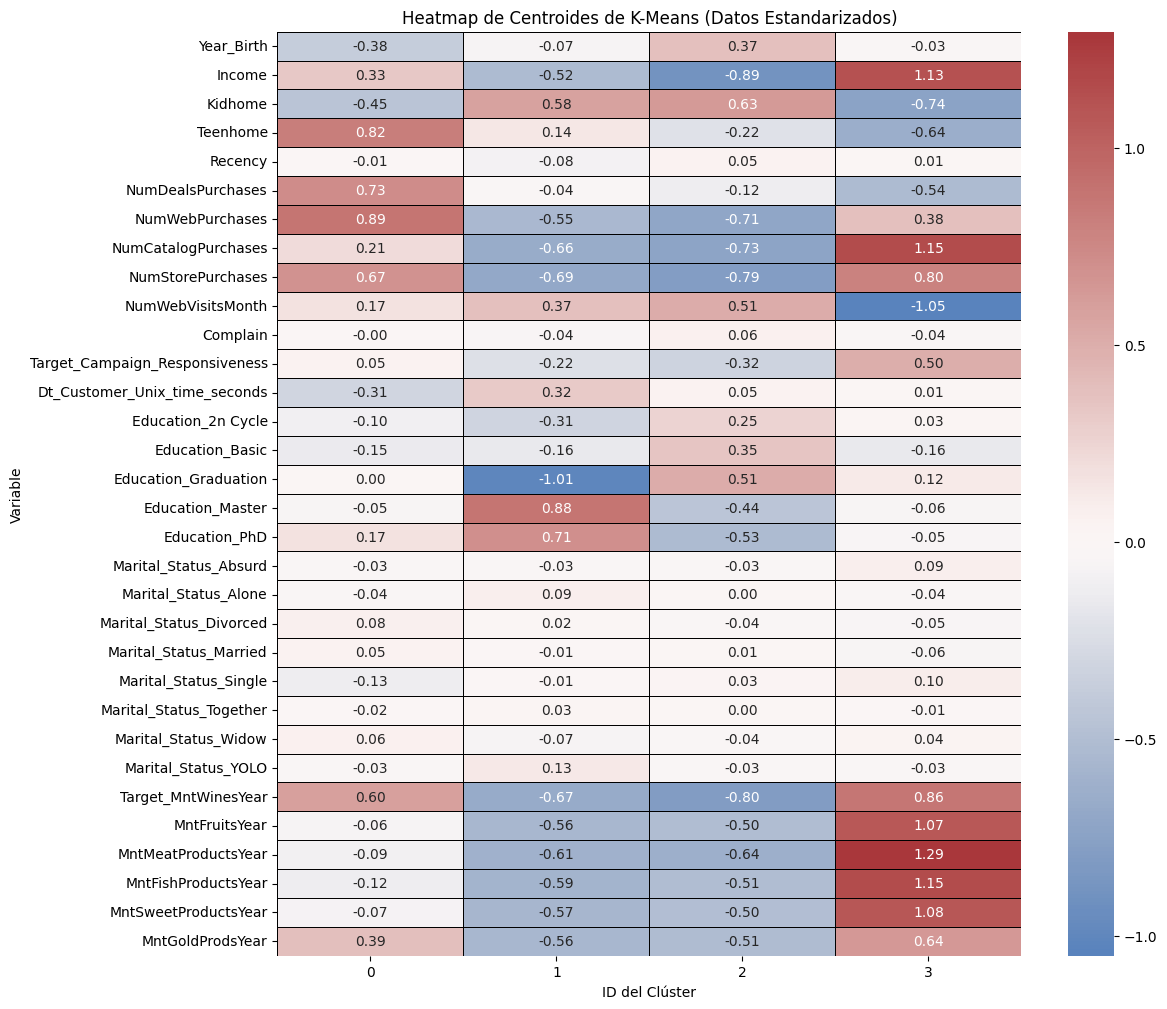

In [146]:
# Vamos a tratar de determinar qué importancia se da a cada variable predictora en cada cluster:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


column_names = X_scaled_df.columns
column_names = column_names.delete(column_names.get_loc('Cluster'))

# =================================================================
# MÉTODO: ANÁLISIS DE LOS CENTROIDES (Para identificar la importancia de las variables)
# =================================================================
print("--- 🔬 1. Análisis de los Centroides Estandarizados (Importancia por Desviación) ---")

# Obtener los centroides
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns=column_names)
centroids_scaled.index.name = 'Cluster'

# print("\nValores de Centroides Estandarizados:")
# print(centroids_scaled.round(2))

# Cálculo de la 'Importancia' basado en la desviación de los centroides
# Una mayor desviación indica que la variable varía mucho entre clústeres,
# lo que la hace importante para la separación.
centroid_std = centroids_scaled.std().sort_values(ascending=False)

print("\nRanking de Importancia por Desviación Estándar de Centroides:")
print(centroid_std.round(4))

# --- Visualización del Centroide ---
plt.figure(figsize=(12, 12))
sns.heatmap(centroids_scaled.T, annot=True, fmt=".2f", cmap="vlag", center=0, 
            linewidths=.5, linecolor='black')
plt.title('Heatmap de Centroides de K-Means (Datos Estandarizados)')
plt.xlabel('ID del Clúster')
plt.ylabel('Variable')
plt.show()

# Las variables cuyos centroides tienen valores absolutos altos (lejos de 0) 
# en uno o más clústeres son las más importantes para definirlos.
# 

print("\n" + "="*50 + "\n")


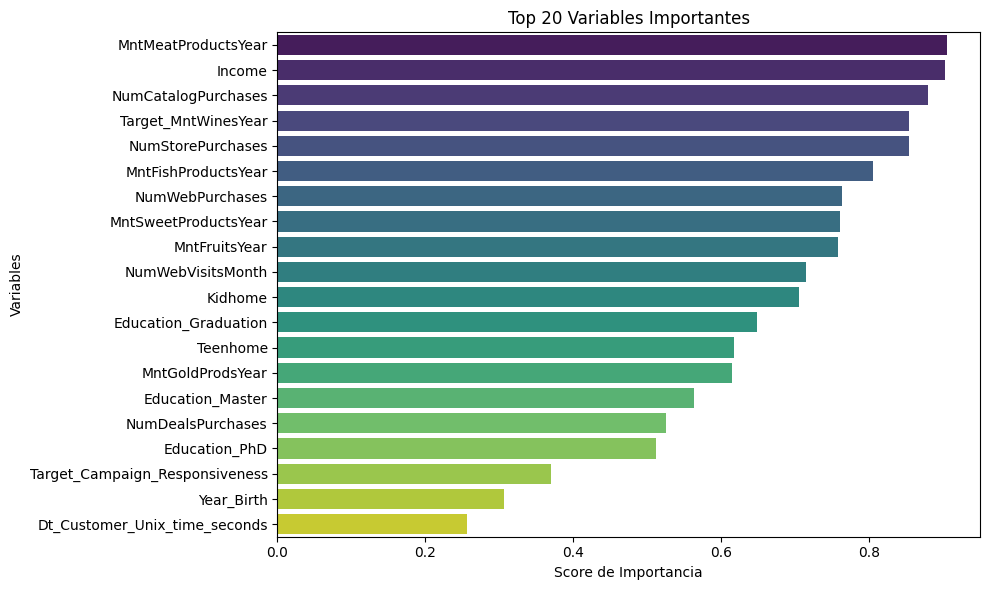

In [147]:
# Vamos a dibujar también la importancia de las variables para separar los clusters:

# Crear DataFrame para facilitar el gráfico
feature_imp_df = pd.DataFrame({
    'Feature': centroid_std.index,
    'Importance': centroid_std.values
}).sort_values(by='Importance', ascending=False)

# Visualización
plt.figure(figsize=(10, 6))

# Graficamos solo las Top 20 features para no saturar si hay muchas columnas
top_n = 20
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_imp_df.head(top_n), 
    palette='viridis',
    hue='Feature' # Asignar hue a Feature para evitar advertencia de deprecación futura
)

plt.title(f'Top {top_n} Variables Importantes')
plt.xlabel('Score de Importancia')
plt.ylabel('Variables')
plt.tight_layout()
plt.show()

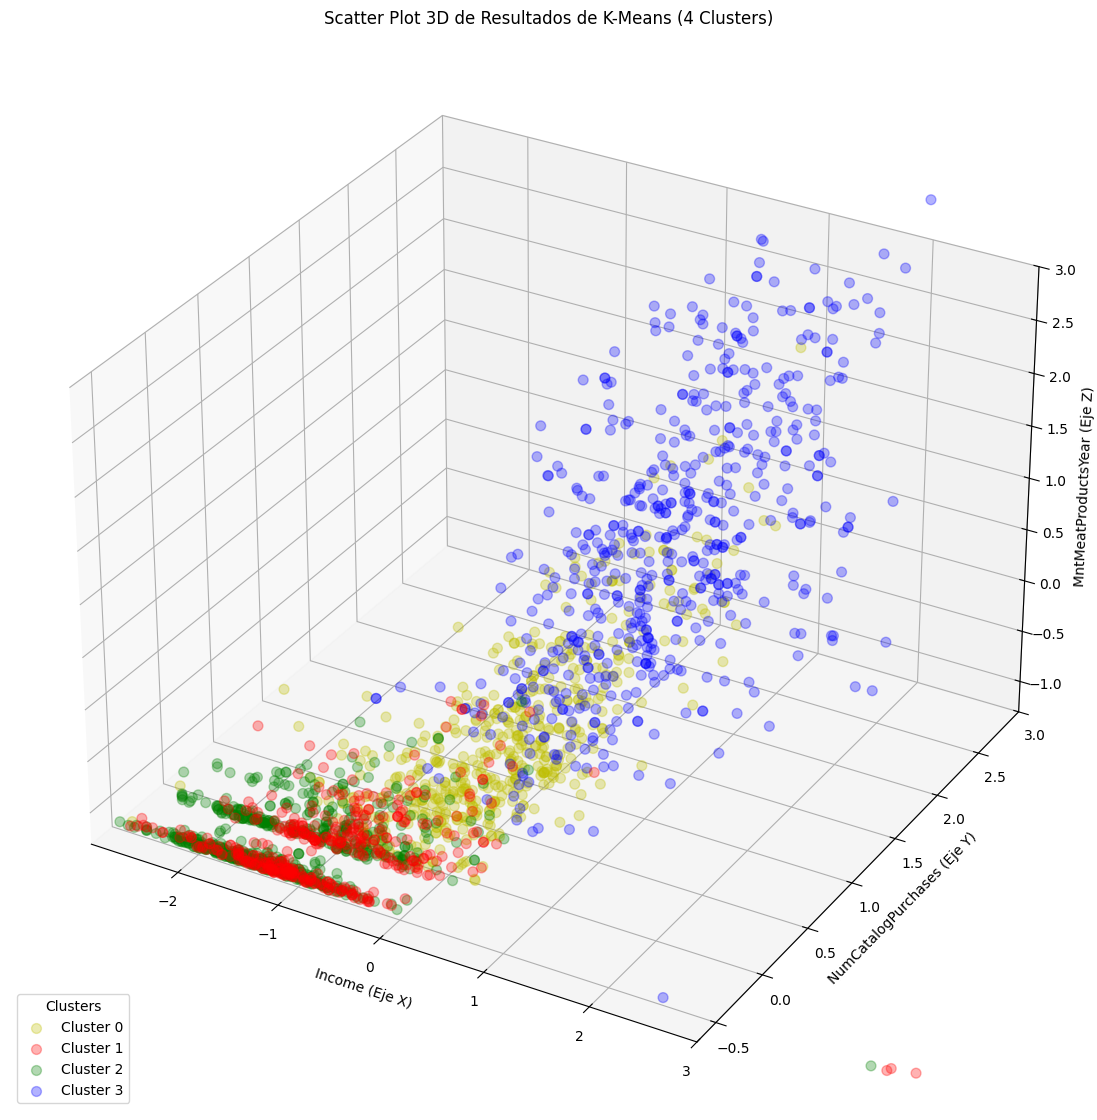

In [148]:
# Representamos en un gráfico 3D la segregación entre Clusters, utilizando las 3 variables com mayor importancia:
# - MntMeatProductsYear
# - Income
# - NumCatalogPurchases

#from mpl_toolkits.mplot3d import Axes3D

etiquetas_kmeans = kmeans.labels_ 

df_plot = X_scaled_df[['MntMeatProductsYear', 'Income', 'NumCatalogPurchases', 'Cluster']]
# *****************************************

# --- 2. GENERACIÓN DEL GRÁFICO 3D ---
# -----------------------------------

# Crear la figura y los ejes 3D
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')

# Definir los colores para cada cluster
# Puedes usar un mapa de colores o una lista de colores específica
colores = ['y', 'r', 'g', 'b'] # Rojo, Verde, Azul, Amarillo

# Iterar sobre cada cluster para graficar los puntos
for cluster_num in sorted(df_plot['Cluster'].unique()):
    # Seleccionar solo los puntos que pertenecen al cluster actual
    subset = df_plot[df_plot['Cluster'] == cluster_num]

    # Graficar los puntos
    ax.scatter(
        subset['Income'],          # Eje X
        subset['NumCatalogPurchases'],          # Eje Y
        subset['MntMeatProductsYear'],          # Eje Z
        c=colores[cluster_num],      # Color del cluster
        marker='o',                  # Forma del punto
        s=50,                        # Tamaño del punto
        label=f'Cluster {cluster_num}', # Etiqueta para la leyenda
        alpha=0.3 # Permitir algo de transparencia
    )

# Configurar las etiquetas de los ejes y el título
ax.set_xlabel('Income (Eje X)')
ax.set_ylabel('NumCatalogPurchases (Eje Y)')
ax.set_zlabel('MntMeatProductsYear (Eje Z)')
ax.set_title('Scatter Plot 3D de Resultados de K-Means (4 Clusters)')
ax.set_xlim(right=3)
ax.set_ylim(top=3, bottom=-0.7)
ax.set_zlim(top=3)

# Añadir leyenda para identificar los clusters
ax.legend(title="Clusters", loc="lower left")

# Mostrar el gráfico
plt.show()

# --- NOTA IMPORTANTE ---
# Una vez que ejecutes el código, en muchas interfaces como Jupyter/Colab, 
# podrás interactuar con el gráfico, rotarlo y hacer zoom para 
# una mejor visualización de la separación de los clusters.

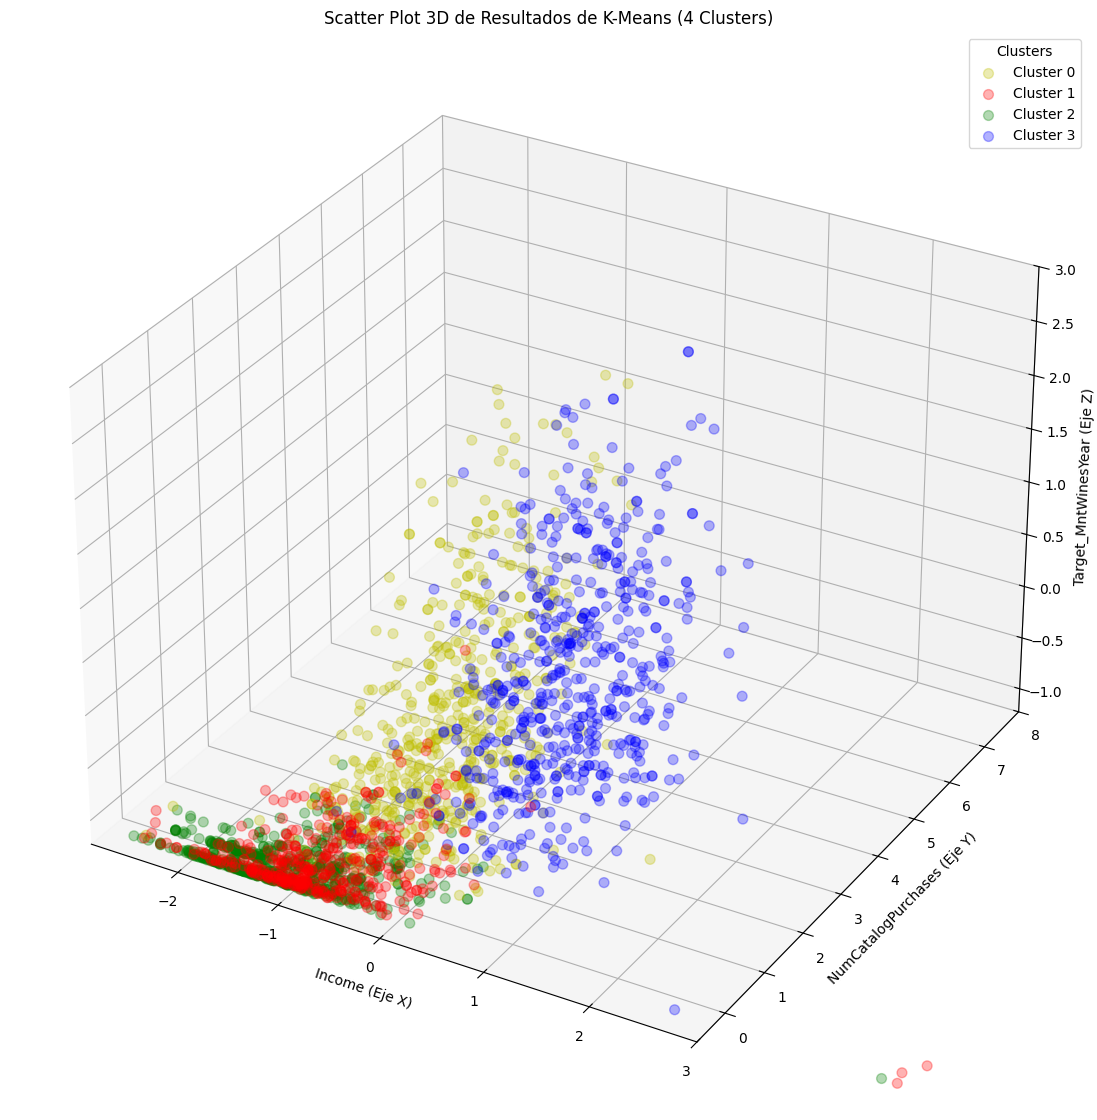

In [149]:
# Representamos la variable 'Target_MntWinesYear' por cluster en base a otras dos variables donde vemos discriminación de cara a esta predicción

#from mpl_toolkits.mplot3d import Axes3D

etiquetas_kmeans = kmeans.labels_ 

df_plot = X_scaled_df[['NumCatalogPurchases', 'Income', 'Target_MntWinesYear', 'Cluster']]
# *****************************************

# --- 2. GENERACIÓN DEL GRÁFICO 3D ---
# -----------------------------------

# Crear la figura y los ejes 3D
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')

# Definir los colores para cada cluster
# Puedes usar un mapa de colores o una lista de colores específica
colores = ['y', 'r', 'g', 'b'] # Rojo, Verde, Azul, Amarillo

# Iterar sobre cada cluster para graficar los puntos
for cluster_num in sorted(df_plot['Cluster'].unique()):
    # Seleccionar solo los puntos que pertenecen al cluster actual
    subset = df_plot[df_plot['Cluster'] == cluster_num]

    # Graficar los puntos
    ax.scatter(
        subset['Income'],          # Eje X
        subset['NumCatalogPurchases'],          # Eje Y
        subset['Target_MntWinesYear'],          # Eje Z
        c=colores[cluster_num],      # Color del cluster
        marker='o',                  # Forma del punto
        s=50,                        # Tamaño del punto
        label=f'Cluster {cluster_num}', # Etiqueta para la leyenda
        alpha=0.3 # Permitir algo de transparencia
    )

# Configurar las etiquetas de los ejes y el título
ax.set_xlabel('Income (Eje X)')
ax.set_ylabel('NumCatalogPurchases (Eje Y)')
ax.set_zlabel('Target_MntWinesYear (Eje Z)')
ax.set_title('Scatter Plot 3D de Resultados de K-Means (4 Clusters)')
ax.set_xlim(right=3)
ax.set_ylim(top=8, bottom=-0.7)
ax.set_zlim(top=3)


# Añadir leyenda para identificar los clusters
ax.legend(title="Clusters")

# Mostrar el gráfico
plt.show()

# --- NOTA IMPORTANTE ---
# Una vez que ejecutes el código, en muchas interfaces como Jupyter/Colab, 
# podrás interactuar con el gráfico, rotarlo y hacer zoom para 
# una mejor visualización de la separación de los clusters.

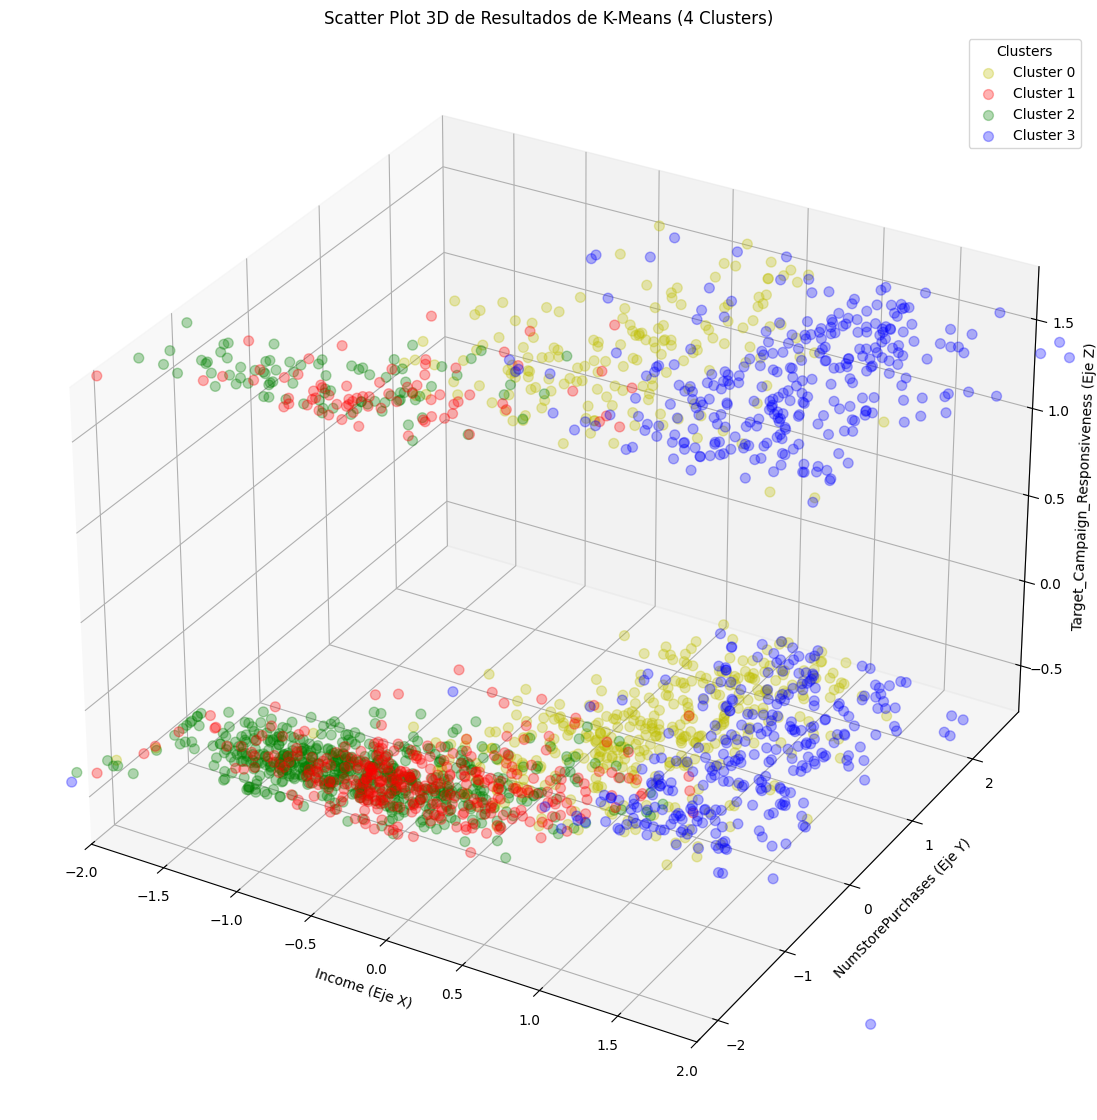

In [150]:
# Representamos la variable 'Target_Campaign_Responsiveness' por cluster en base a otras dos variables donde vemos discriminación de cara a esta predicción

#from mpl_toolkits.mplot3d import Axes3D

etiquetas_kmeans = kmeans.labels_ 

df_plot = X_scaled_df[['NumStorePurchases', 'Income', 'Target_Campaign_Responsiveness', 'Cluster']]
# *****************************************

# --- 2. GENERACIÓN DEL GRÁFICO 3D ---
# -----------------------------------

# Función para añadir ruido, la necesitamos para que los puntos del scatter no salgan solapados uno encima de otro
def add_jitter(series, amount=0.1):
    return series + np.random.uniform(-amount, amount, size=len(series))

# Crear la figura y los ejes 3D
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')

# Definir los colores para cada cluster
# Puedes usar un mapa de colores o una lista de colores específica
colores = ['y', 'r', 'g', 'b'] # Rojo, Verde, Azul, Amarillo

# Iterar sobre cada cluster para graficar los puntos
for cluster_num in sorted(df_plot['Cluster'].unique()):
    # Seleccionar solo los puntos que pertenecen al cluster actual
    subset = df_plot[df_plot['Cluster'] == cluster_num]

    # Graficar los puntos
    ax.scatter(
        subset['Income'],          # Eje X
        add_jitter(subset['NumStorePurchases'],0.25),          # Eje Y
        subset['Target_Campaign_Responsiveness'],          # Eje Z
        c=colores[cluster_num],      # Color del cluster
        marker='o',                  # Forma del punto
        s=50,                        # Tamaño del punto
        label=f'Cluster {cluster_num}', # Etiqueta para la leyenda
        alpha=0.3 # Permitir algo de transparencia
    )

# Configurar las etiquetas de los ejes y el título
ax.set_xlabel('Income (Eje X)')
ax.set_ylabel('NumStorePurchases (Eje Y)')
ax.set_zlabel('Target_Campaign_Responsiveness (Eje Z)')
ax.set_title('Scatter Plot 3D de Resultados de K-Means (4 Clusters)')
ax.set_xlim(left=-2, right=2)


# Añadir leyenda para identificar los clusters
ax.legend(title="Clusters")

# Mostrar el gráfico
plt.show()

# --- NOTA IMPORTANTE ---
# Una vez que ejecutes el código, en muchas interfaces como Jupyter/Colab, 
# podrás interactuar con el gráfico, rotarlo y hacer zoom para 
# una mejor visualización de la separación de los clusters.

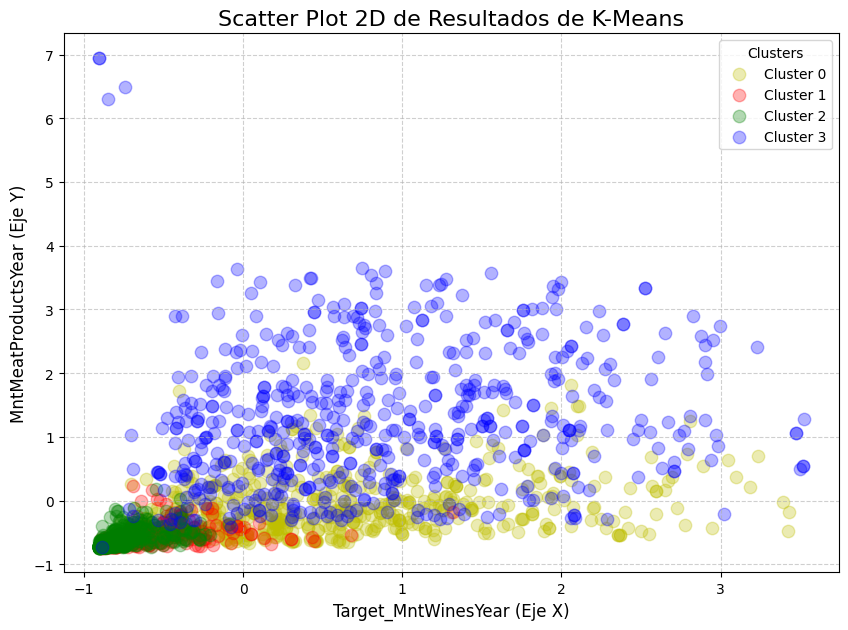

In [151]:
# Miramos en un gráfico 2D el MEJOR predictor que tenemos (MntMeatProductsYear) para separar entre cluster, y lo comparamos con su consumo de vino

# *****************************************
# --- 2. GENERACIÓN DEL GRÁFICO 2D ---
# -----------------------------------

df_plot_2d = X_scaled_df.copy()
df_plot_2d['Cluster'] = etiquetas_kmeans


plt.figure(figsize=(10, 7))

# Definir los colores para cada cluster 
colores = ['y', 'r', 'g', 'b'] # Rojo, Verde, Azul, Amarillo

# Iterar sobre cada cluster para graficar los puntos por separado
for cluster_num in sorted(df_plot_2d['Cluster'].unique()):
    # Seleccionar solo los puntos que pertenecen al cluster actual
    subset = df_plot_2d[df_plot_2d['Cluster'] == cluster_num]

    # Graficar los puntos
    plt.scatter(
        subset['Target_MntWinesYear'],         # Eje X
        subset['MntMeatProductsYear'],         # Eje Y
        c=colores[cluster_num],      # Color del cluster
        marker='o',                  # Forma del punto
        s=80,                        # Tamaño del punto
        alpha=0.3,                   # Transparencia
        label=f'Cluster {cluster_num}' # Etiqueta para la leyenda
    )

# Configurar el gráfico
plt.title('Scatter Plot 2D de Resultados de K-Means', fontsize=16)
plt.xlabel('Target_MntWinesYear (Eje X)', fontsize=12)
plt.ylabel('MntMeatProductsYear (Eje Y)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Añadir leyenda para identificar los clusters
plt.legend(title="Clusters", loc='best')

# Mostrar el gráfico
plt.show()

In [152]:
# A este gráfico anterior, vamos a meterle una dimensión adicional para tratar de diferenciar los clusters 1 y 2 (rojo-verde), que aparecen muy solapados

In [153]:

# # *****************************************
# # --- 2. GENERACIÓN DEL GRÁFICO 2D ---
# # -----------------------------------

# df_plot_2d = X_scaled_df.copy()
# df_plot_2d['Cluster'] = etiquetas_kmeans


# plt.figure(figsize=(20, 20))

# # Definir los colores para cada cluster 
# colores = ['y', 'r', 'g', 'b'] # Rojo, Verde, Azul, Amarillo

# g =sns.lmplot(
#     x="NumCatalogPurchases", 
#     y="Income", 
#     hue="Cluster", 
#     data=df_plot_2d, 
#     scatter_kws={'alpha': 0.3},
#     x_jitter=0.1, 
#     y_jitter=0.1, 
#     palette=['y', 'r', 'g', 'b'],
#     fit_reg=False)

# # Establecer límites ignorando outliers para una mejor separación entre Clusters
# g.set(xlim=(-2, 4), ylim=(-3, 3))


# # Mostrar el gráfico
# plt.show()

In [154]:
# # Al gráfico anterior le vamos a añadir una tercera dimensión de una variable que nos permita ver separación entre los Clusters 1 y 2 (rojo-verde) que nos quedan solapados

# #from mpl_toolkits.mplot3d import Axes3D

# etiquetas_kmeans = kmeans.labels_ 

# df_plot = X_scaled_df[['NumCatalogPurchases', 'Income', 'Education_Graduation', 'Cluster']]
# # *****************************************

# # --- 2. GENERACIÓN DEL GRÁFICO 3D ---
# # -----------------------------------

# # Crear la figura y los ejes 3D
# fig = plt.figure(figsize=(14, 14))
# ax = fig.add_subplot(111, projection='3d')

# # Definir los colores para cada cluster
# # Puedes usar un mapa de colores o una lista de colores específica
# colores = ['y', 'r', 'g', 'b'] # Rojo, Verde, Azul, Amarillo

# # Iterar sobre cada cluster para graficar los puntos
# for cluster_num in sorted(df_plot['Cluster'].unique()):
#     # Seleccionar solo los puntos que pertenecen al cluster actual
#     subset = df_plot[df_plot['Cluster'] == cluster_num]

#     # Graficar los puntos
#     ax.scatter(
#         subset['Education_Graduation'],          # Eje X
#         subset['NumCatalogPurchases'],          # Eje Y
#         subset['Income'],          # Eje Z
#         c=colores[cluster_num],      # Color del cluster
#         marker='o',                  # Forma del punto
#         s=50,                        # Tamaño del punto
#         label=f'Cluster {cluster_num}', # Etiqueta para la leyenda
#         alpha=0.3 # Permitir algo de transparencia
#     )

# # Configurar las etiquetas de los ejes y el título
# ax.set_xlabel('Education_Graduation (Eje X)')
# ax.set_ylabel('NumCatalogPurchases (Eje Y)')
# ax.set_zlabel('Income (Eje Z)')
# ax.set_title('Scatter Plot 3D de Resultados de K-Means (4 Clusters)')
# ax.set_xlim(right=2)
# ax.set_ylim(top=3)
# ax.set_zlim(top=3)


# # Añadir leyenda para identificar los clusters
# ax.legend(title="Clusters")

# # Mostrar el gráfico
# plt.show()

# # --- NOTA IMPORTANTE ---
# # Una vez que ejecutes el código, en muchas interfaces como Jupyter/Colab, 
# # podrás interactuar con el gráfico, rotarlo y hacer zoom para 
# # una mejor visualización de la separación de los clusters.

<Figure size 2000x2000 with 0 Axes>

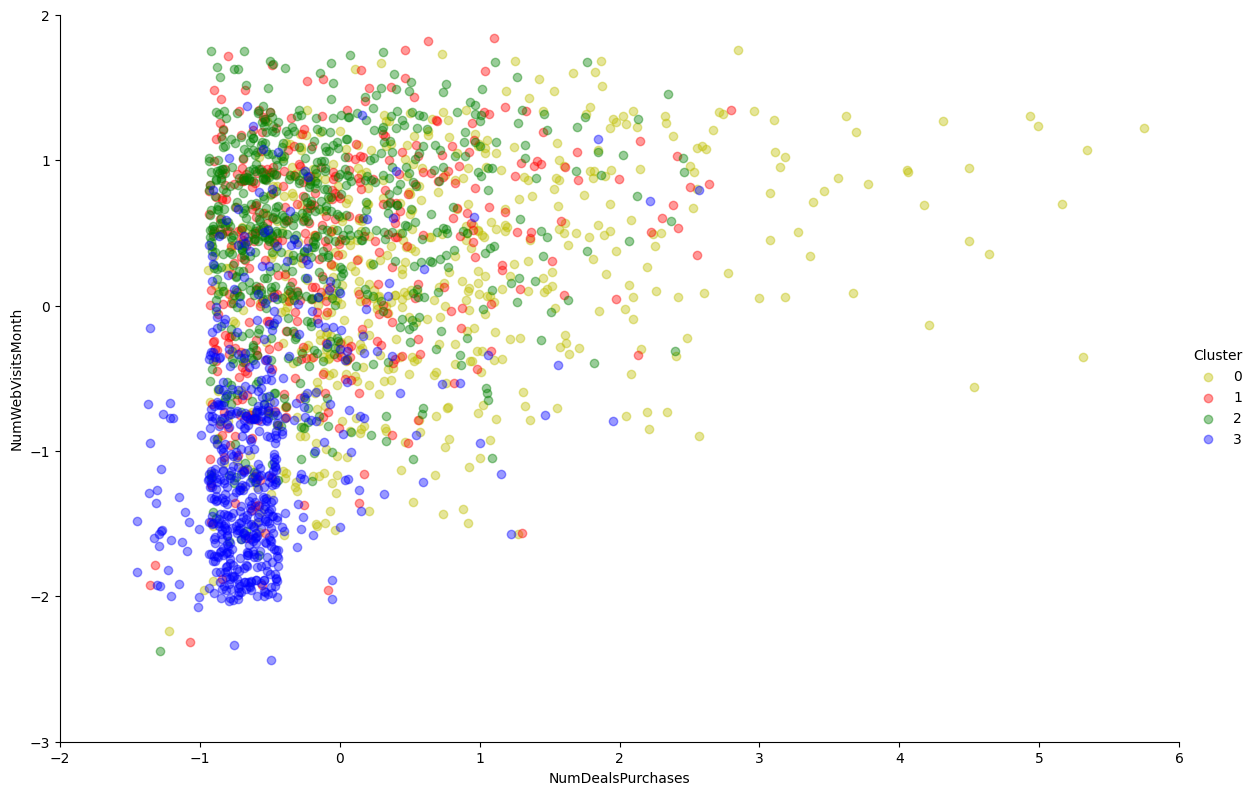

In [155]:
# Variables que más se alejan entre sí para diferenciar Cluster 0 y Cluster 3:
# Teenhome: 1.46 (la descartamos porque prácticamente sólo tiene 3 valores)
# MntMeatProductsYear: 1.38 (la descartamos porque ya la hemos mostrado en el gráfico de las variables con más impacto)
# NumDealsPurchases: 1.27
# NumWebVisitsMonth: 1.22

# *****************************************
# --- 2. GENERACIÓN DEL GRÁFICO 2D ---
# -----------------------------------

df_plot_2d = X_scaled_df.copy()
df_plot_2d['Cluster'] = etiquetas_kmeans


plt.figure(figsize=(20, 20))

# Definir los colores para cada cluster 
colores = ['y', 'r', 'g', 'b'] # Rojo, Verde, Azul, Amarillo

g =sns.lmplot(
    x="NumDealsPurchases", 
    y="NumWebVisitsMonth", 
    hue="Cluster", 
    data=df_plot_2d, 
    height=8, 
    aspect=1.5,
    scatter_kws={'alpha': 0.4},
    x_jitter=0.25, 
    y_jitter=0.25,  
    palette=['y', 'r', 'g', 'b'],
    fit_reg=False)

# Establecer límites ignorando outliers para una mejor separación entre Clusters
g.set(xlim=(-2, 6), ylim=(-3, 2))


# Mostrar el gráfico
plt.show()

<Figure size 2000x2000 with 0 Axes>

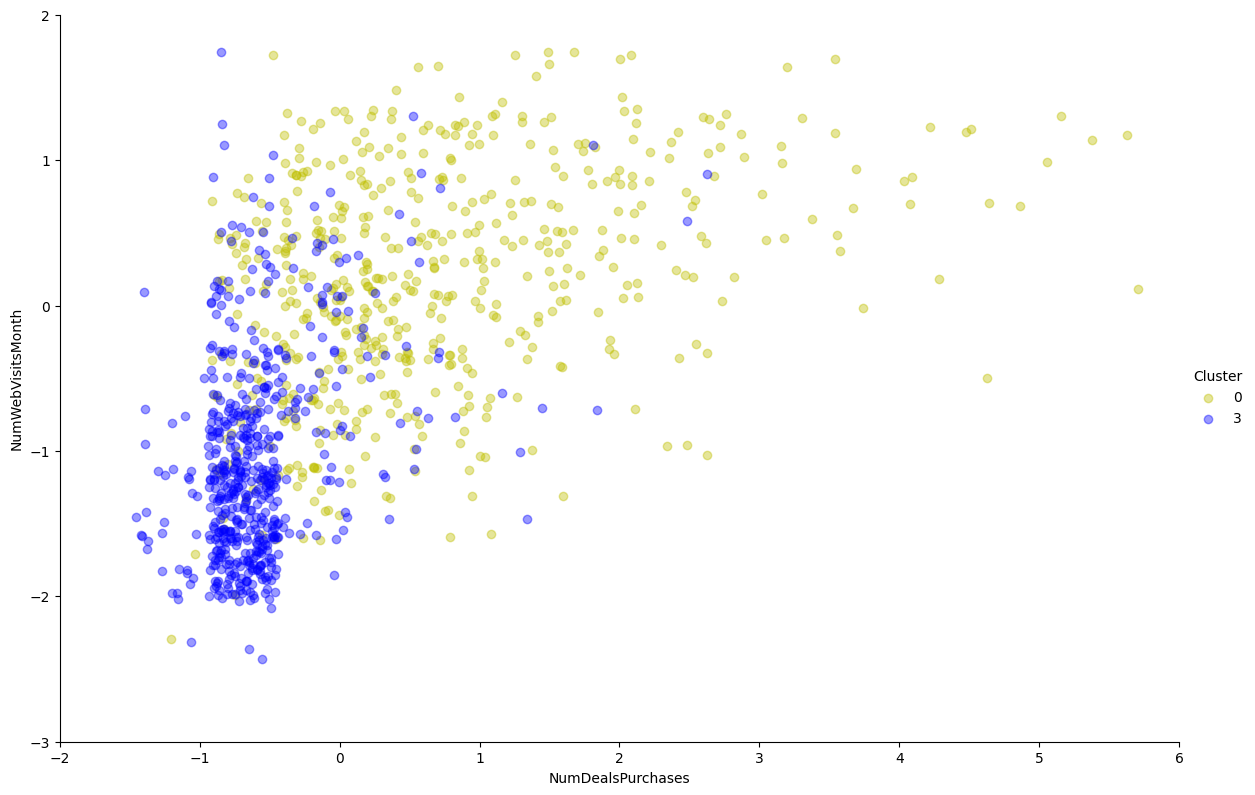

In [156]:
# Vamos a quitar los clusters rojo y verde para ver mejor cómo se dividen el azul y el amarillo

# *****************************************
# --- 2. GENERACIÓN DEL GRÁFICO 2D ---
# -----------------------------------

df_plot_2d = X_scaled_df.copy()
df_plot_2d['Cluster'] = etiquetas_kmeans

mask = df_plot_2d['Cluster'].isin([0, 3]) # Máscara para filtrar sólo los clusteres 0 y 3
df_plot_2d = df_plot_2d[mask]


plt.figure(figsize=(20, 20))

# Definir los colores para cada cluster 
colores = ['y', 'b'] #  Azul, Amarillo

g =sns.lmplot(
    x="NumDealsPurchases", 
    y="NumWebVisitsMonth", 
    hue="Cluster", 
    data=df_plot_2d, 
    height=8, 
    aspect=1.5,
    scatter_kws={'alpha': 0.4},
    x_jitter=0.25, 
    y_jitter=0.25, 
    palette=colores,
    fit_reg=False)

# Establecer límites ignorando outliers para una mejor separación entre Clusters
g.set(xlim=(-2, 6), ylim=(-3, 2))


# Mostrar el gráfico
plt.show()

<Figure size 2000x2000 with 0 Axes>

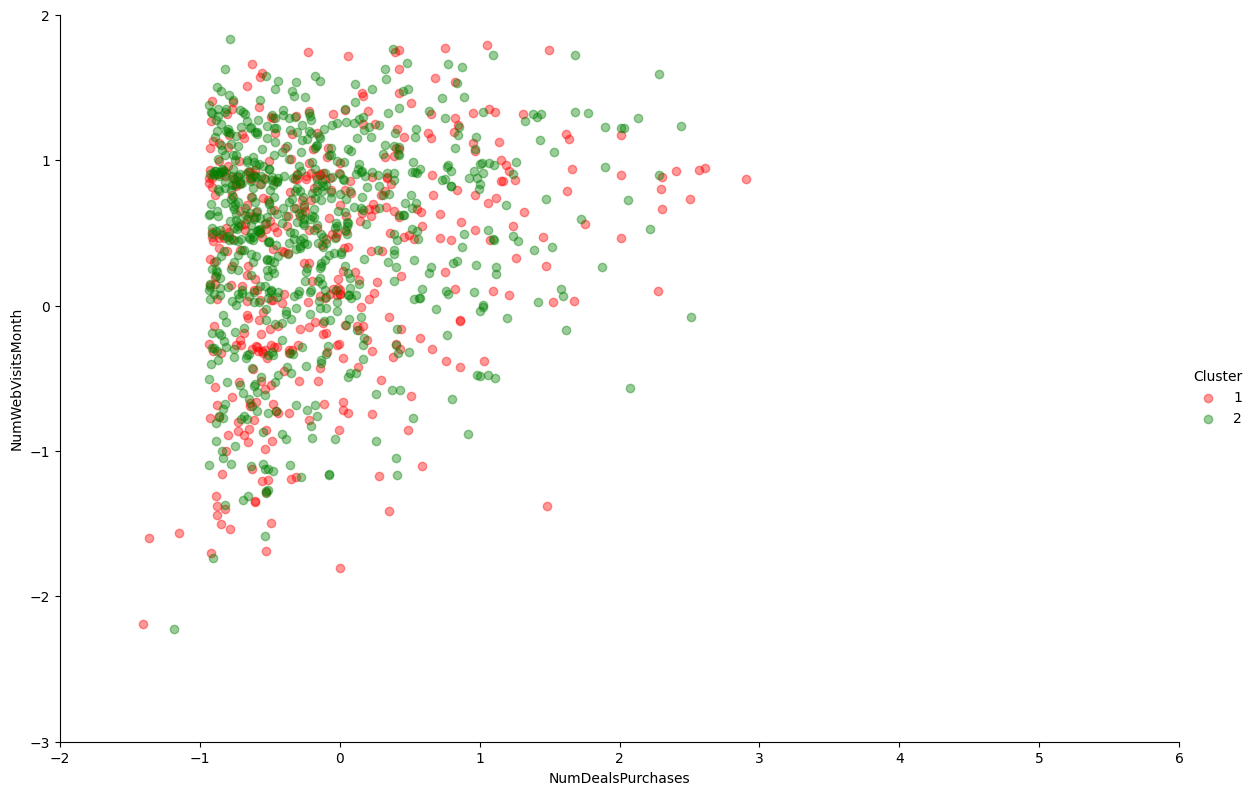

In [157]:
# Veamos solamente los clusters 1 y 2 (rojo-verde)
# Vamos a quitar los amarillo y azul   para ver mejor cómo se dividen el rojo y verde

# *****************************************
# --- 2. GENERACIÓN DEL GRÁFICO 2D ---
# -----------------------------------

df_plot_2d = X_scaled_df.copy()
df_plot_2d['Cluster'] = etiquetas_kmeans

mask = df_plot_2d['Cluster'].isin([1, 2]) # Máscara para filtrar sólo los clusteres 1 y 2
df_plot_2d = df_plot_2d[mask]


plt.figure(figsize=(20, 20))

# Definir los colores para cada cluster 
colores = ['r', 'g'] #  Azul, Amarillo

g =sns.lmplot(
    x="NumDealsPurchases", 
    y="NumWebVisitsMonth", 
    hue="Cluster", 
    data=df_plot_2d, 
    height=8, 
    aspect=1.5,
    scatter_kws={'alpha': 0.4},
    x_jitter=0.25, 
    y_jitter=0.25, 
    palette=colores,
    fit_reg=False)

# Establecer límites ignorando outliers para una mejor separación entre Clusters
g.set(xlim=(-2, 6), ylim=(-3, 2))


# Mostrar el gráfico
plt.show()

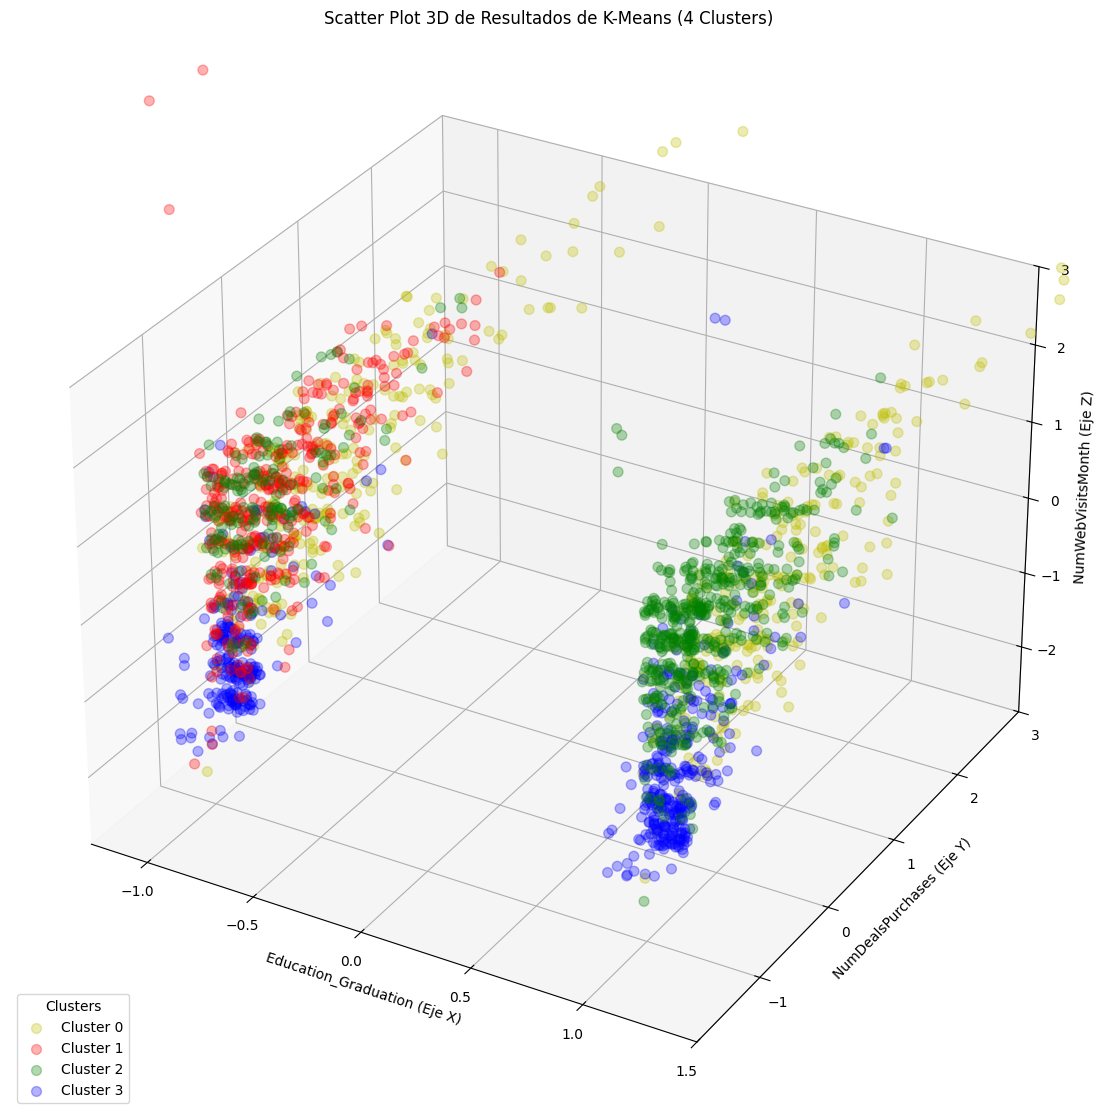

In [159]:
# Probamos a introducirle una tercera dimensión que separe bien los clusters 1 y 2 (rojo-verde): Education_Graduation

# Función para añadir ruido, la necesitamos para que los puntos del scatter no salgan solapados uno encima de otro
def add_jitter(series, amount=0.1):
    return series + np.random.uniform(-amount, amount, size=len(series))

#from mpl_toolkits.mplot3d import Axes3D

etiquetas_kmeans = kmeans.labels_ 

df_plot = X_scaled_df[['NumDealsPurchases', 'NumWebVisitsMonth', 'Education_Graduation', 'Cluster']]
# *****************************************

# --- 2. GENERACIÓN DEL GRÁFICO 3D ---
# -----------------------------------

# Crear la figura y los ejes 3D
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')

# Definir los colores para cada cluster
# Puedes usar un mapa de colores o una lista de colores específica
colores = ['y', 'r', 'g', 'b'] # Rojo, Verde, Azul, Amarillo

# Iterar sobre cada cluster para graficar los puntos
for cluster_num in sorted(df_plot['Cluster'].unique()):
    # Seleccionar solo los puntos que pertenecen al cluster actual
    subset = df_plot[df_plot['Cluster'] == cluster_num]

    # Graficar los puntos
    ax.scatter(
        add_jitter(subset['Education_Graduation']),          # Eje X
        add_jitter(subset['NumDealsPurchases']),          # Eje Y
        add_jitter(subset['NumWebVisitsMonth']),          # Eje Z
        c=colores[cluster_num],      # Color del cluster
        marker='o',                  # Forma del punto
        s=50,                        # Tamaño del punto
        label=f'Cluster {cluster_num}', # Etiqueta para la leyenda
        alpha=0.3 # Permitir algo de transparencia
    )

# Configurar las etiquetas de los ejes y el título
ax.set_xlabel('Education_Graduation (Eje X)')
ax.set_ylabel('NumDealsPurchases (Eje Y)')
ax.set_zlabel('NumWebVisitsMonth (Eje Z)')
ax.set_title('Scatter Plot 3D de Resultados de K-Means (4 Clusters)')
ax.set_xlim(right=1.5)
ax.set_ylim(top=3)
ax.set_zlim(top=3)


# Añadir leyenda para identificar los clusters
ax.legend(title="Clusters", loc="lower left")

# Mostrar el gráfico
plt.show()

# --- NOTA IMPORTANTE ---
# Una vez que ejecutes el código, en muchas interfaces como Jupyter/Colab, 
# podrás interactuar con el gráfico, rotarlo y hacer zoom para 
# una mejor visualización de la separación de los clusters.